**References:** 

https://gist.github.com/ShawnHymel/79237fe6aee5a3653c497d879f746c0c 

https://github.com/arduino/ArduinoTensorFlowLiteTutorials/

https://colab.research.google.com/github/tensorflow/examples/blob/master/lite/codelabs/digit_classifier/ml/step2_train_ml_model.ipynb


In [ ]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import random

In [ ]:
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
# Each pixel's value will range from 0 to 1 
train_images = train_images / 255.0
test_images = test_images / 255.0

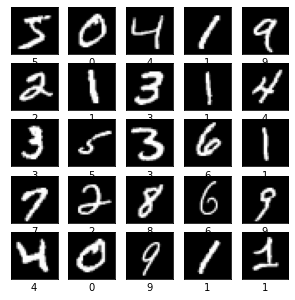

In [ ]:
# Visualize sample of 25 images from dataset
plt.figure(figsize=(5,5))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(train_images[i], cmap=plt.cm.gray)
  plt.xlabel(train_labels[i])
plt.show()

In [ ]:
# Model architecture
model = keras.Sequential([
  keras.layers.InputLayer(input_shape=(28, 28)),
  keras.layers.Reshape(target_shape=(28, 28, 1)),
  keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation=tf.nn.relu),
  keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation=tf.nn.relu),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Dropout(0.25),
  keras.layers.Flatten(),
  keras.layers.Dense(10)
])

# Compile model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train sequential classification model
history = model.fit(train_images, train_labels, epochs= 20)

Epoch 1/20
1875/1875 [==============================] - 149s 79ms/step - loss: 0.2981 - accuracy: 0.9090
Epoch 2/20
1875/1875 [==============================] - 149s 80ms/step - loss: 0.0568 - accuracy: 0.9823
Epoch 3/20
1875/1875 [==============================] - 149s 79ms/step - loss: 0.0410 - accuracy: 0.9880
Epoch 4/20
1875/1875 [==============================] - 144s 77ms/step - loss: 0.0302 - accuracy: 0.9905
Epoch 5/20
1875/1875 [==============================] - 142s 76ms/step - loss: 0.0231 - accuracy: 0.9926
Epoch 6/20
1875/1875 [==============================] - 148s 79ms/step - loss: 0.0194 - accuracy: 0.9938
Epoch 7/20
1875/1875 [==============================] - 151s 80ms/step - loss: 0.0159 - accuracy: 0.9946
Epoch 8/20
1875/1875 [==============================] - 150s 80ms/step - loss: 0.0132 - accuracy: 0.9954
Epoch 9/20
1875/1875 [==============================] - 149s 80ms/step - loss: 0.0122 - accuracy: 0.9959
Epoch 10/20
1875/1875 [==============================] 

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                9

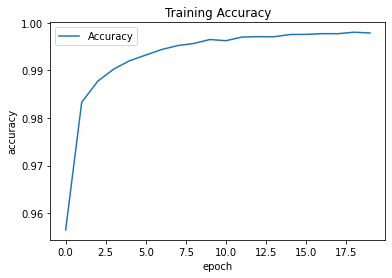

In [ ]:
# Training accuracy vs epoch
plt.plot(history.history['accuracy'])
plt.title('Training Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Accuracy'], loc='upper left')
plt.show()

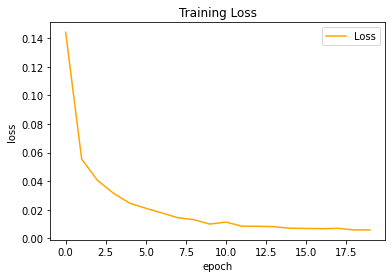

In [ ]:
# Training loss vs epoch
plt.plot(history.history['loss'], color='orange')
plt.title('Training Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Loss'], loc='upper right')
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test acc:', test_acc)

313/313 [==============================] - 7s 21ms/step - loss: 0.0592 - accuracy: 0.9883
Test acc: 0.9883000254631042


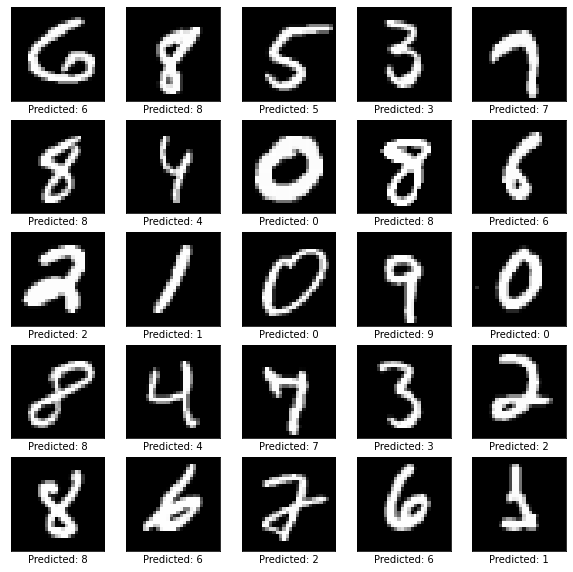

In [ ]:
# Function for the prediction's label color
def get_label_color(value1, value2):
  if value1 == value2:
    return 'black'
  else:
    return 'red'

# Predict  labels of images in test dataset
predictions = model.predict(test_images)
prediction_digits = np.argmax(predictions, axis=1)

# Plot a sample of 100 test images and their predicted labels
# Based on "get_label_color" function, red text indicates wrong prediction 
plt.figure(figsize=(10, 10))
for i in range(25):
  ax = plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  image_index = random.randint(0, len(prediction_digits))
  plt.imshow(test_images[image_index], cmap=plt.cm.gray)
  ax.xaxis.label.set_color(get_label_color(prediction_digits[image_index],\
                                           test_labels[image_index]))
  plt.xlabel('Predicted: %d' % prediction_digits[image_index])
plt.show()

In [ ]:
#####################################################################
# Takes Keras model and converts it to TFL model for use on arduino #
#####################################################################

tflite_model_name = 'OseeR_model'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

open(tflite_model_name + '.tflite', 'wb').write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpkpo4xih7/assets


INFO:tensorflow:Assets written to: /tmp/tmpkpo4xih7/assets


117088

In [ ]:
###################################################
# This section converts tflite model into C array #
###################################################

# Function: Convert some hex value into an array for C programming
def hex_to_c_array(hex_data, var_name):

  c_str = ''

  # Create header guard
  c_str += '#ifndef ' + var_name.upper() + '_H\n'
  c_str += '#define ' + var_name.upper() + '_H\n\n'

  # Add array length at top of file
  c_str += '\nunsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

  # Declare C variable
  c_str += 'unsigned char ' + var_name + '[] = {'
  hex_array = []
  for i, val in enumerate(hex_data) :

    # Construct string from hex
    hex_str = format(val, '#04x')

    # Add formatting so each line stays within 80 characters
    if (i + 1) < len(hex_data):
      hex_str += ','
    if (i + 1) % 12 == 0:
      hex_str += '\n '
    hex_array.append(hex_str)

  # Add closing brace
  c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

  # Close out header guard
  c_str += '#endif //' + var_name.upper() + '_H'

  return c_str

In [ ]:
###################################################
# Convert C array into .h file for use in arduino #
###################################################

# Write TFLite model to a C source (or header) file

c_model_name = 'OseeR_model'

with open(c_model_name + '.h', 'w') as file:
  file.write(hex_to_c_array(tflite_model, c_model_name))